In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## В этом модуле мы построим классификатор, который позволит своевременно определять уходящих клиентов банка.

* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которые приобрёл клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [3]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [4]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [5]:
# Проверим, что в наших данных нет пропусков:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [6]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [7]:
# Перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [8]:
# Разделим набор данных на матрицу наблюдений X и столбец ответов y:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [9]:
# Проведём нормализацию матрицы наблюдений X:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [11]:
y.value_counts(normalize=True)
# классы не сбалансированы

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным.

train_test_split() из библиотеки sklearn умеет производить такое разбиение! Для этого в функции предусмотрен параметр stratify, который нужно выставить в значение признака. Признак должен иметь одинаковые соотношения в тренировочной и тестовой выборках. У нас этим признаком является целевой признак y.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [15]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


In [16]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42 # , #генератор случайных чисел
    # max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

In [24]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print('Тренировочная выборка ___________________________________')
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print('Тестовая выборка ________________________________________')
print(metrics.classification_report(y_test, y_test_pred))

Тренировочная выборка ___________________________________
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

Тестовая выборка ________________________________________
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.63      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.69      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



## ПОЛИНОМИАЛЬНЫЕ ПРИЗНАКИ

In [25]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


In [32]:
#Создаем объект класса логистическая регрессия
lr_model_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42 # , #генератор случайных чисел
    # max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
lr_model_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

print("Train f1: {:.3f}".format(metrics.f1_score(y_train, y_train_predict_poly)))
print("Test f1: {:.3f}".format(metrics.f1_score(y_test, y_test_predict_poly)))
print()
#Вывод отчет о метриках классификации
print('Тренировочная выборка ___________________________________')
print(metrics.classification_report(y_train, y_train_predict_poly))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print('Тестовая выборка ________________________________________')
print(metrics.classification_report(y_test, y_test_predict_poly))

Train R^2: 0.122
Test R^2: 0.049
Train f1: 0.655
Test f1: 0.637

Тренировочная выборка ___________________________________
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

Тестовая выборка ________________________________________
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


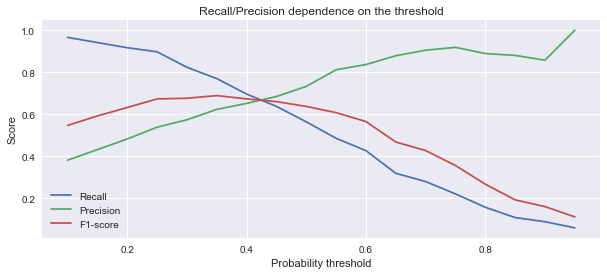

In [34]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = lr_model_poly.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [35]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628

